# Spatial plot of tmax/prate post Krakatoa eruption using 20CR data from 1850-2014
- opens all the C20C (20th century reanalysis data) files with data on precipitation prate and surface temperature tmax
- calculates monthly anomalies (based on 1850-1880 climatology) for 4 spatial regions (global, SH, Aus, E Aus)
- calculates percentiles (10, 90) to show model spread
- generates spatial plots at 4 discrete times following Krakatoa 1883 (Aug 1883, Feb 1884, Aug 1884, Aug 1885)

In [2]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [3]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [4]:
# read in precipitation data
ds_prate = xr.open_mfdataset('/g/data/ua8/C20C/v3/mean_daily/prate/*.nc', combine='by_coords', chunks={'time': 12})

In [5]:
# read in temperature data
ds_tmax = xr.open_mfdataset('/g/data/ua8/C20C/v3/mean_daily/tmax_2m/*.nc', combine='by_coords', chunks={'time': 12})

In [6]:
# combine precipitation and temperature into one dataset
C20C = xr.Dataset({'tmax': ds_tmax.tmax, 'prate': ds_prate.prate})
# change the pr units
C20C['prate'] = C20C.prate*86400

In [7]:
# select out time around Kraktoa eruption
C20C = C20C.sel(time=slice('1850-01','1900-01'))

## Area weighting and land frac

In [8]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/ua8/C20C/v3/LAND.nc')
landmask = landfrac_ds.mean(dim='time')

In [9]:
# area weighting 
C20C_w = C20C*np.cos(C20C.lat*(np.pi/180))

## Group the data by month and calculate anomalies

In [10]:
# group the data by month (take the monthly mean)
C20C_mon = C20C_w.resample(time='M').mean(dim='time')

In [11]:
# use functions to calculate the monthly anomalies for the globe
K_mmm_mon_Glob = func.monthly_anomaly(C20C_mon, '1850-01', '1881-01')

In [12]:
# select out regions for other anomalies 
K_mmm_mon_SH = K_mmm_mon_Glob.sel(lat=slice(-90,0)) 
K_mmm_mon_NH = K_mmm_mon_Glob.sel(lat=slice(0,90)) 
K_mmm_mon_Aus = K_mmm_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160))#.where(landmask.data==1, drop=True)
K_mmm_mon_EA = K_mmm_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155))#.where(landmask.data==1, drop=True)

## Figures

In [13]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

In [14]:
# eruption dates
e_date = ['1883-08','1902-10', '1963-03', '1982-04', '1991-06']
e_post6mon = ['1884-02', '1903-04', '1963-09', '1982-10', '1991-12']
e_post12mon = ['1884-08','1903-10', '1964-03', '1983-04', '1992-06']
e_post24mon = ['1885-08','1904-10', '1965-03', '1984-04', '1993-06']

In [15]:
# dates and title for eruption and 3 times after
K_dates = [e_date[0], e_post6mon[0], e_post12mon[0], e_post24mon[0]]
title_label = ['Eruption month, ', '6 months post-eruption, ', '12 months post-eruption, ', '24 months post-eruption, ']

In [16]:
titles=[]
for i,vals in enumerate(K_dates):
    t = title_label[i] + K_dates[i]
    titles.append(t)
titles

['Eruption month, 1883-08',
 '6 months post-eruption, 1884-02',
 '12 months post-eruption, 1884-08',
 '24 months post-eruption, 1885-08']

In [17]:
# set the mod max for the colour bars
cmax_tmax = 2
cmax_prate = 2

# need to fix stuff up here and add in functions for spatial plots 

In [20]:
fplot=reload(fplot)

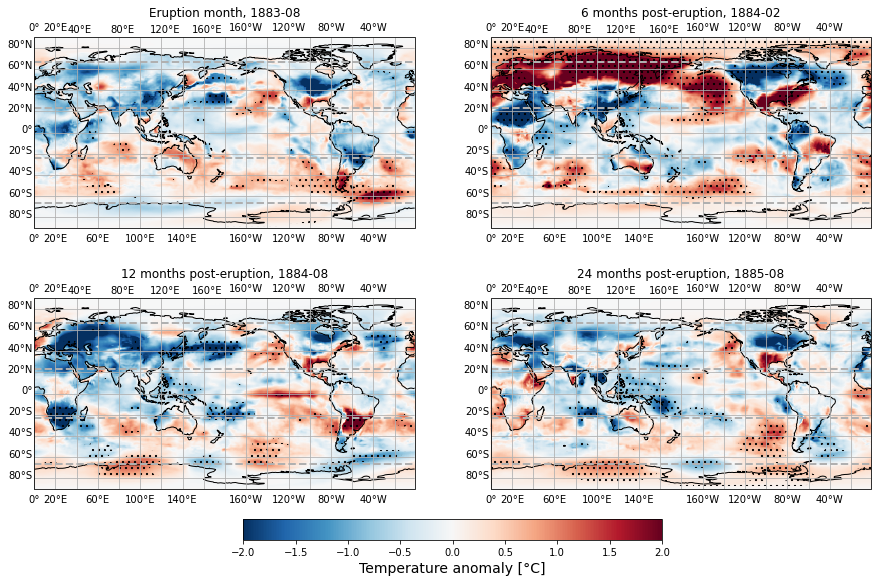

In [21]:
# plot of global monthly reanalysis mean temperature at 4 discrete time periods (not averaged)
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.tmax, cmax_tmax, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmax_Glob.png', dpi=300 , bbox_inches='tight') 

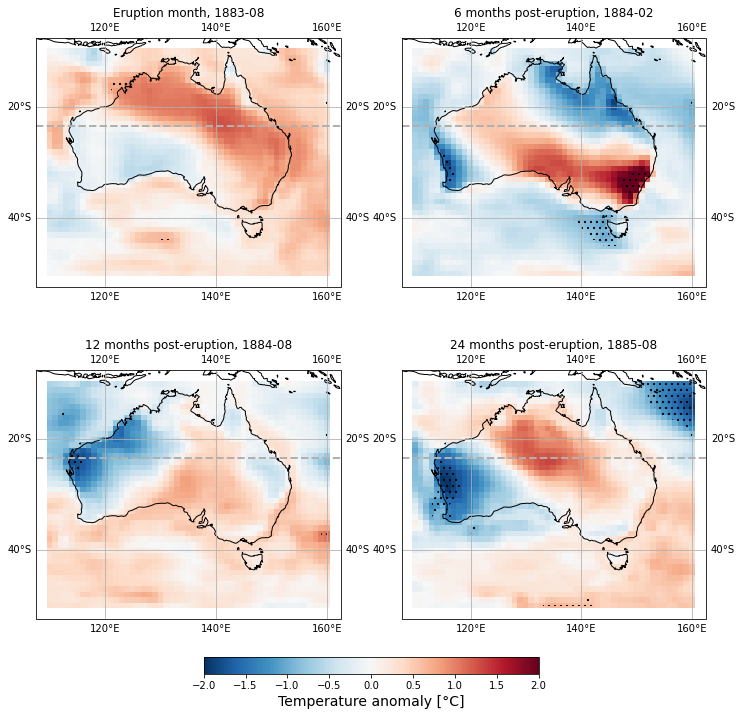

In [53]:
# plot of Aus monthly reanalysis mean temperature
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.tmax, cmax_tmax, K_dates, titles, 'RdBu_r', f'Temperature anomaly [{deg}C]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('R_spatial_tmax_Aus.png', dpi=300, bbox_inches='tight')

### Rainfall

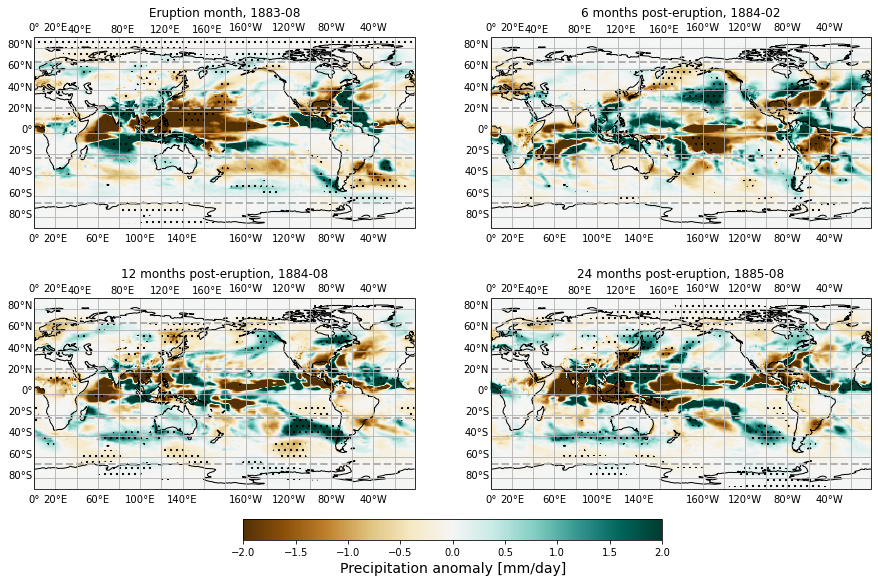

In [57]:
# plot of global monthly reanalysis mean precipitation
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Glob.prate, cmax_prate, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(15)
fig.set_figheight(11) # these two parameters change the figure height and width 

plt.savefig('R_spatial_prate_Glob.png', dpi=300)#, bbox_inches='tight')

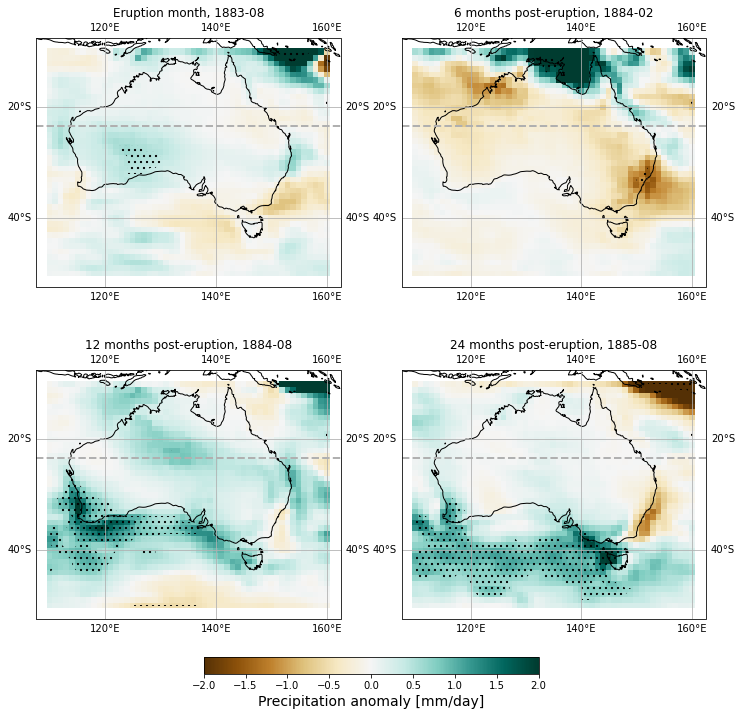

In [58]:
# plot of Aus monthly reanalysis mean precipitation
fig = fplot.spatial_plot(2, 2, K_mmm_mon_Aus.prate, cmax_prate, K_dates, titles, 'BrBG','Precipitation anomaly [mm/day]', 1)

fig.set_figwidth(12)
fig.set_figheight(14) # these two parameters change the figure height and width 

plt.savefig('R_spatial_prate_Aus.png', dpi=300, bbox_inches='tight')

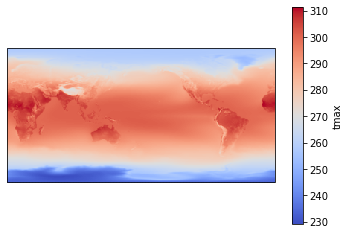

In [23]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(180))
C20C.tmax.mean(dim=['time']).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')

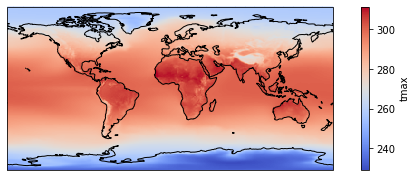

In [25]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))

C20C.tmax.mean(dim=['time']).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines()

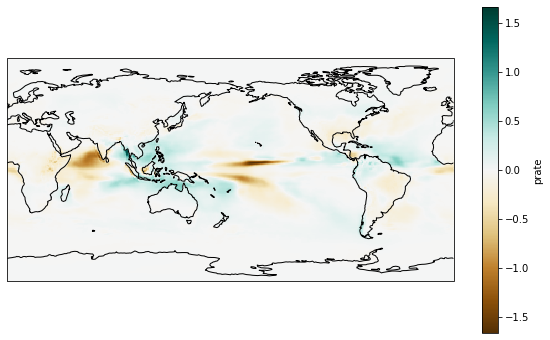

In [39]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(180))

(K_mmm_mon_Glob.prate*86400).mean(dim=['time']).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='BrBG')
ax.coastlines()